In [2]:
# Importing Libraries
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
from warnings import filterwarnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

# Suppress warnings
filterwarnings('ignore')

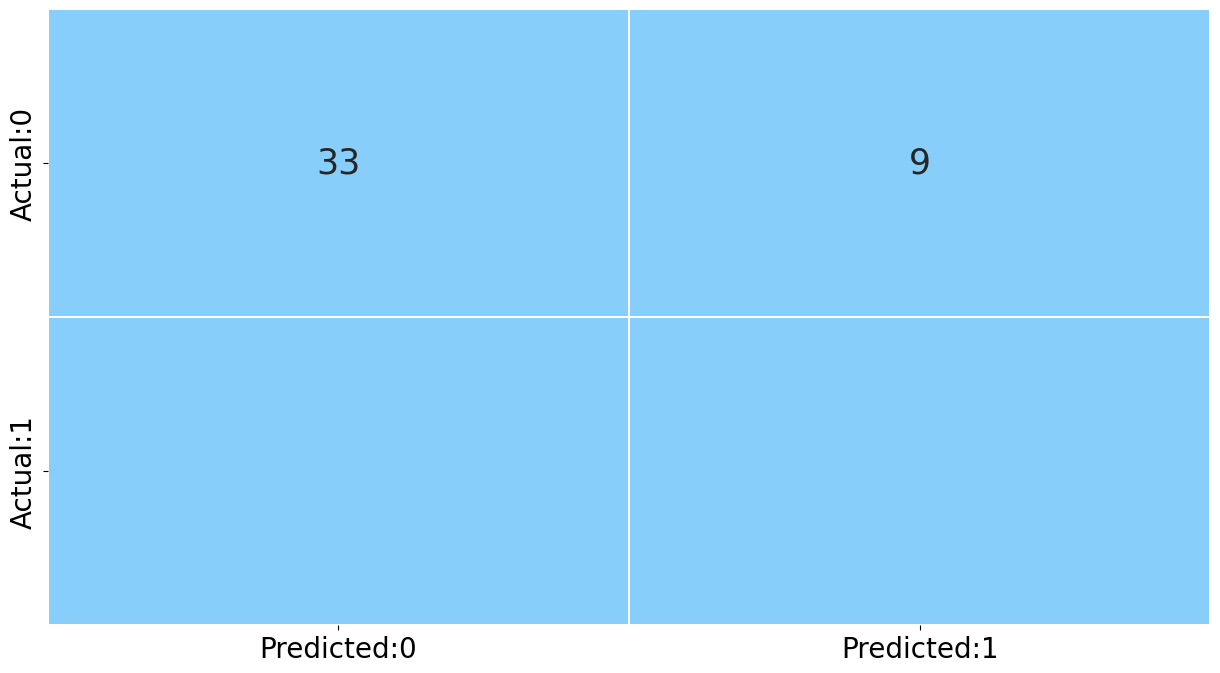

              precision    recall  f1-score   support

           0       0.82      0.79      0.80        42
           1       0.78      0.82      0.79        38

    accuracy                           0.80        80
   macro avg       0.80      0.80      0.80        80
weighted avg       0.80      0.80      0.80        80



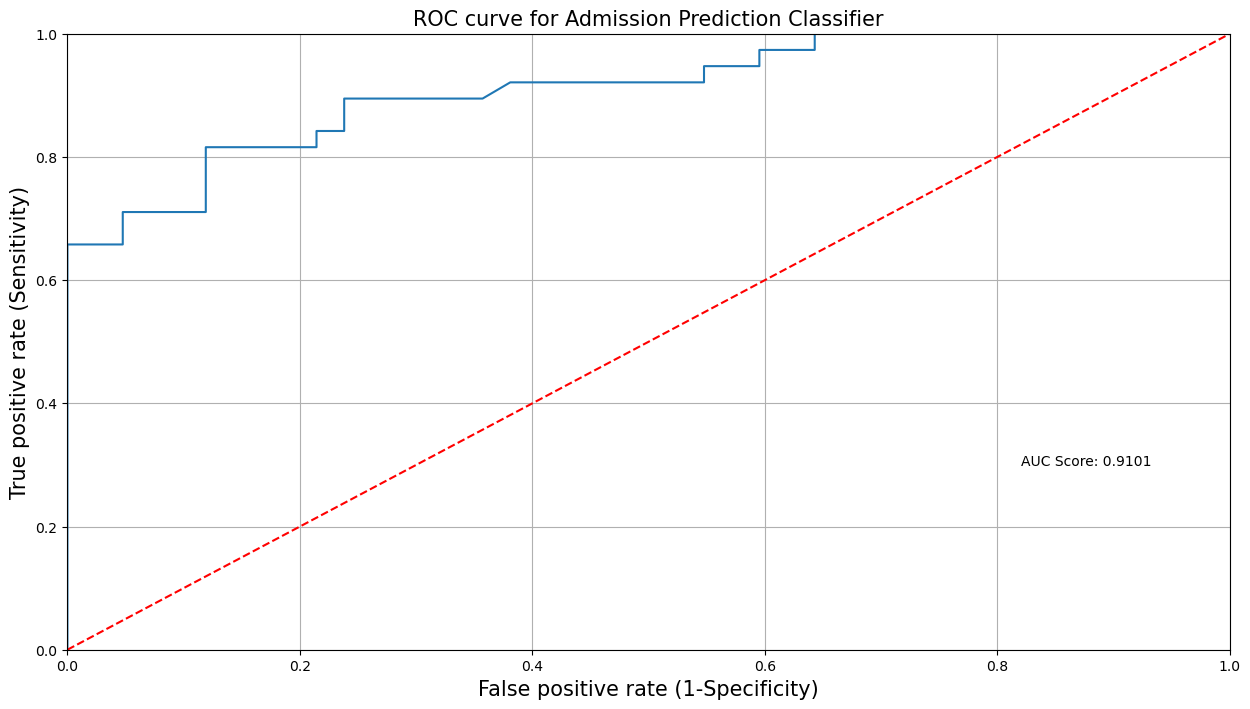

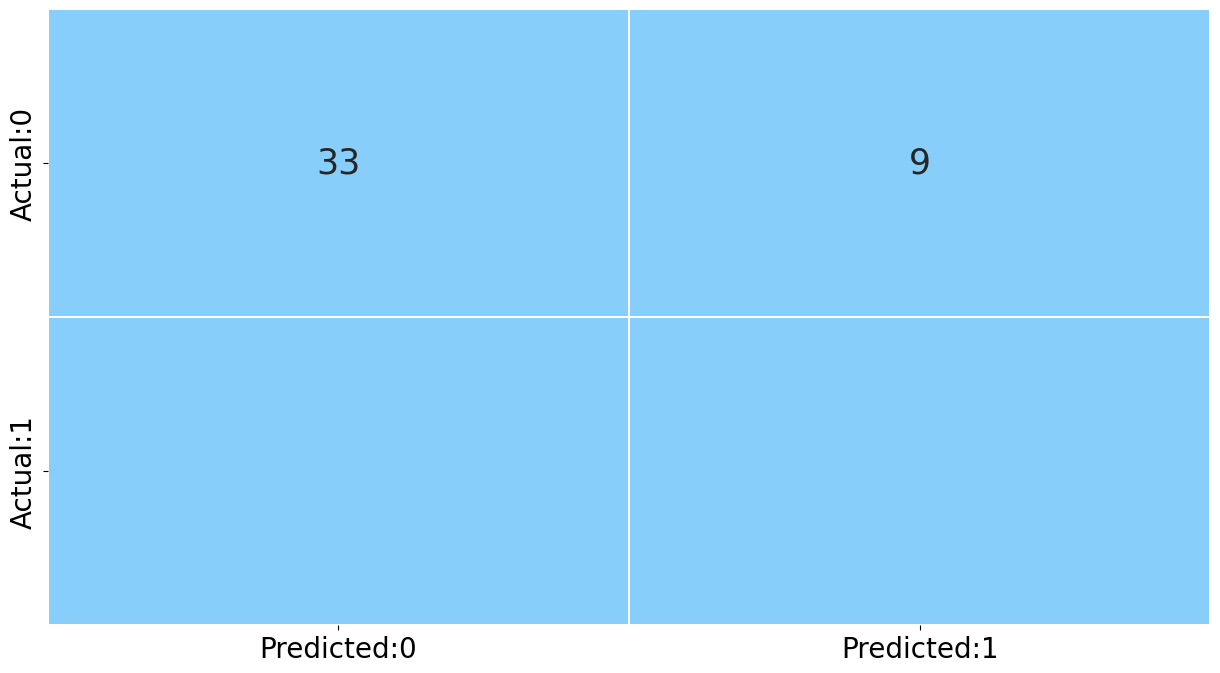

              precision    recall  f1-score   support

           0       0.80      0.79      0.80        42
           1       0.77      0.79      0.78        38

    accuracy                           0.79        80
   macro avg       0.79      0.79      0.79        80
weighted avg       0.79      0.79      0.79        80



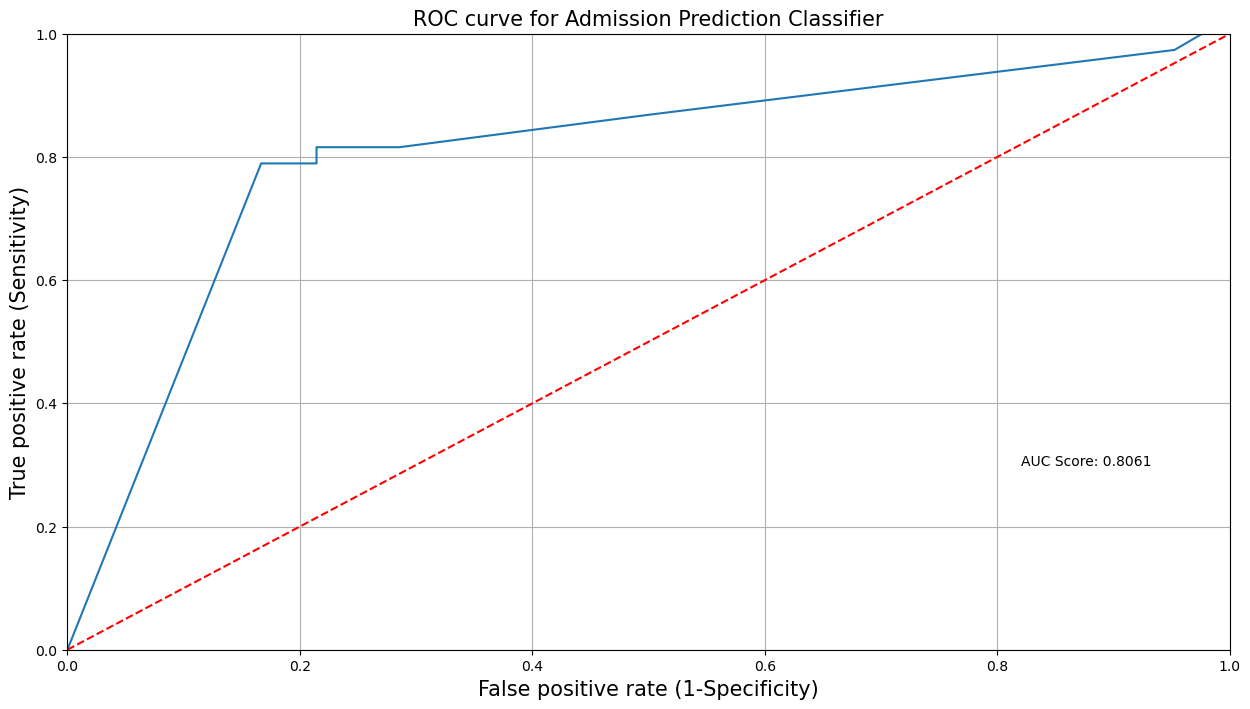

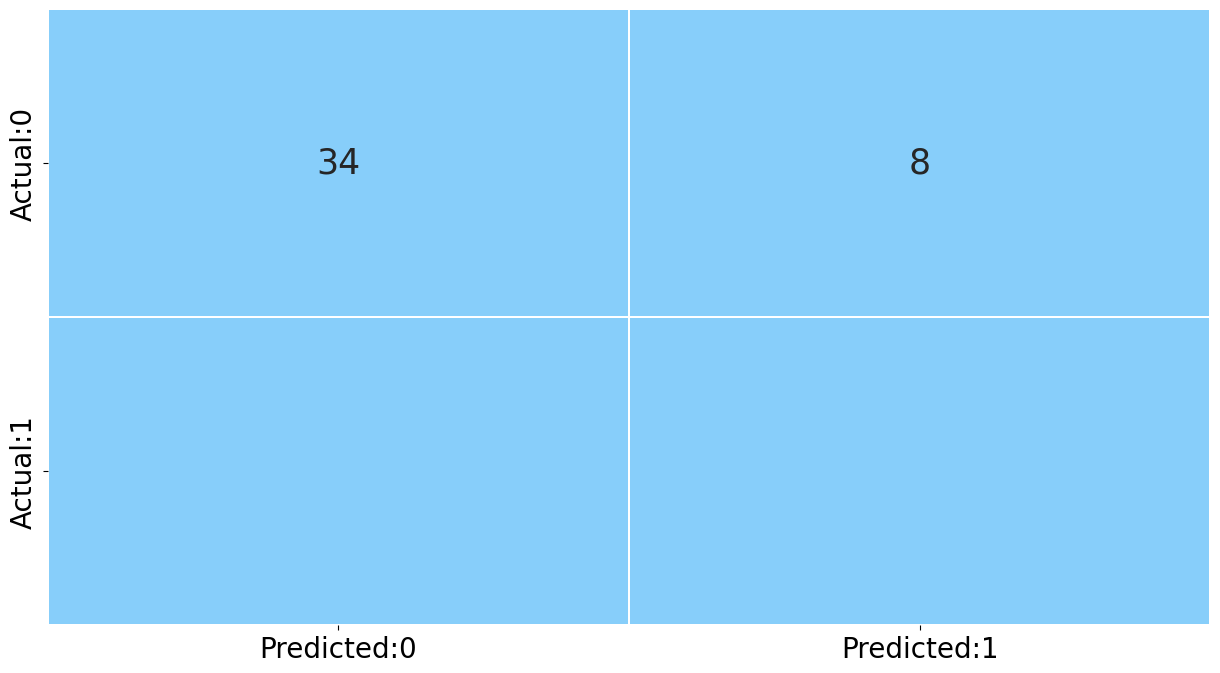

              precision    recall  f1-score   support

           0       0.87      0.81      0.84        42
           1       0.80      0.87      0.84        38

    accuracy                           0.84        80
   macro avg       0.84      0.84      0.84        80
weighted avg       0.84      0.84      0.84        80



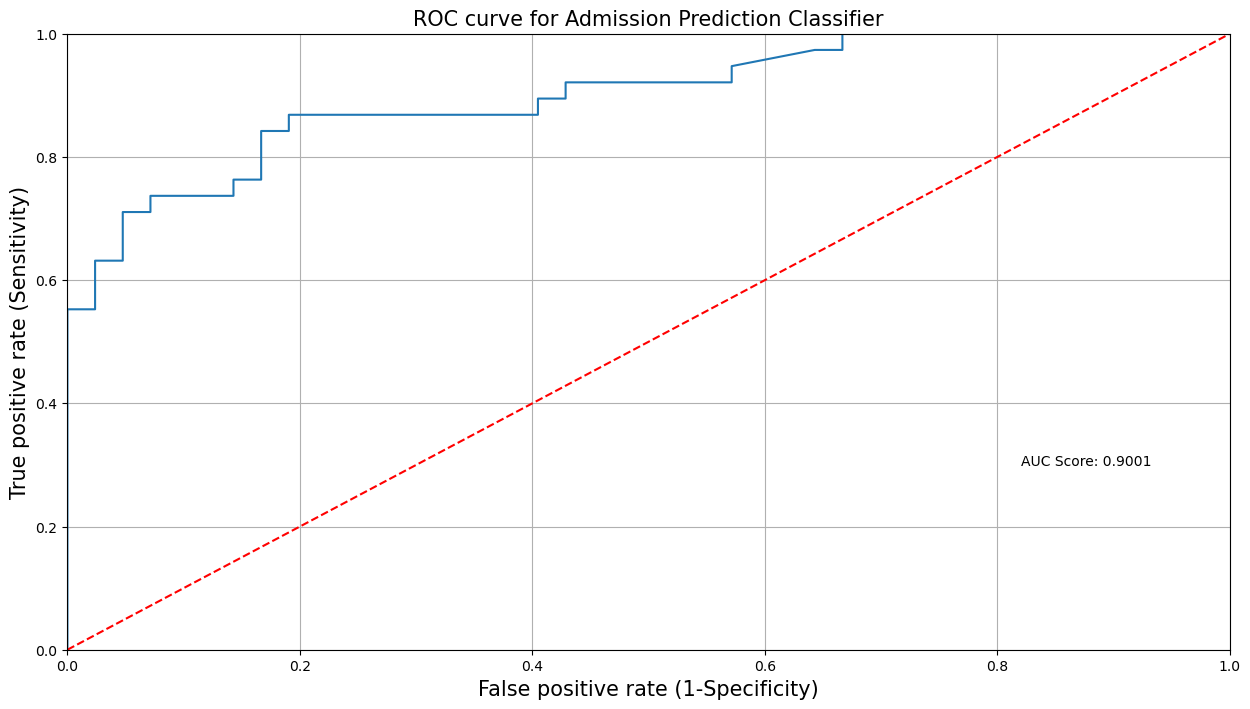

Classification Report for test set:
               precision    recall  f1-score   support

           0       0.87      0.81      0.84        42
           1       0.80      0.87      0.84        38

    accuracy                           0.84        80
   macro avg       0.84      0.84      0.84        80
weighted avg       0.84      0.84      0.84        80



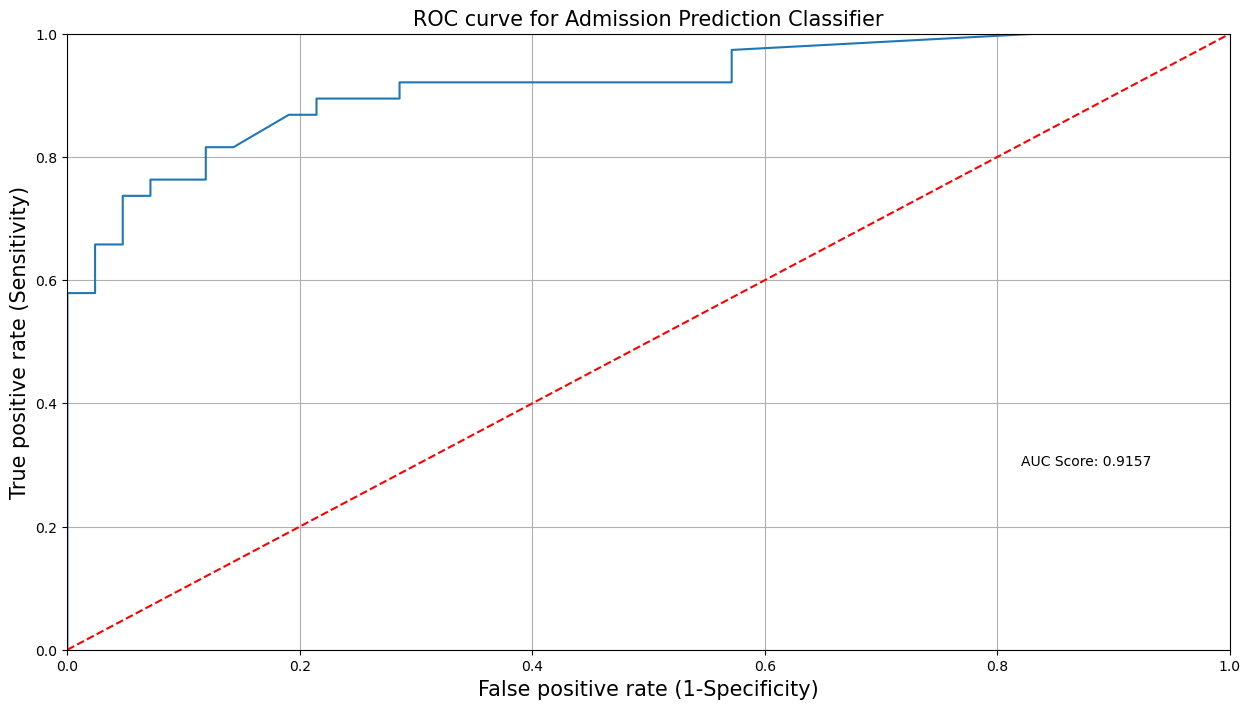

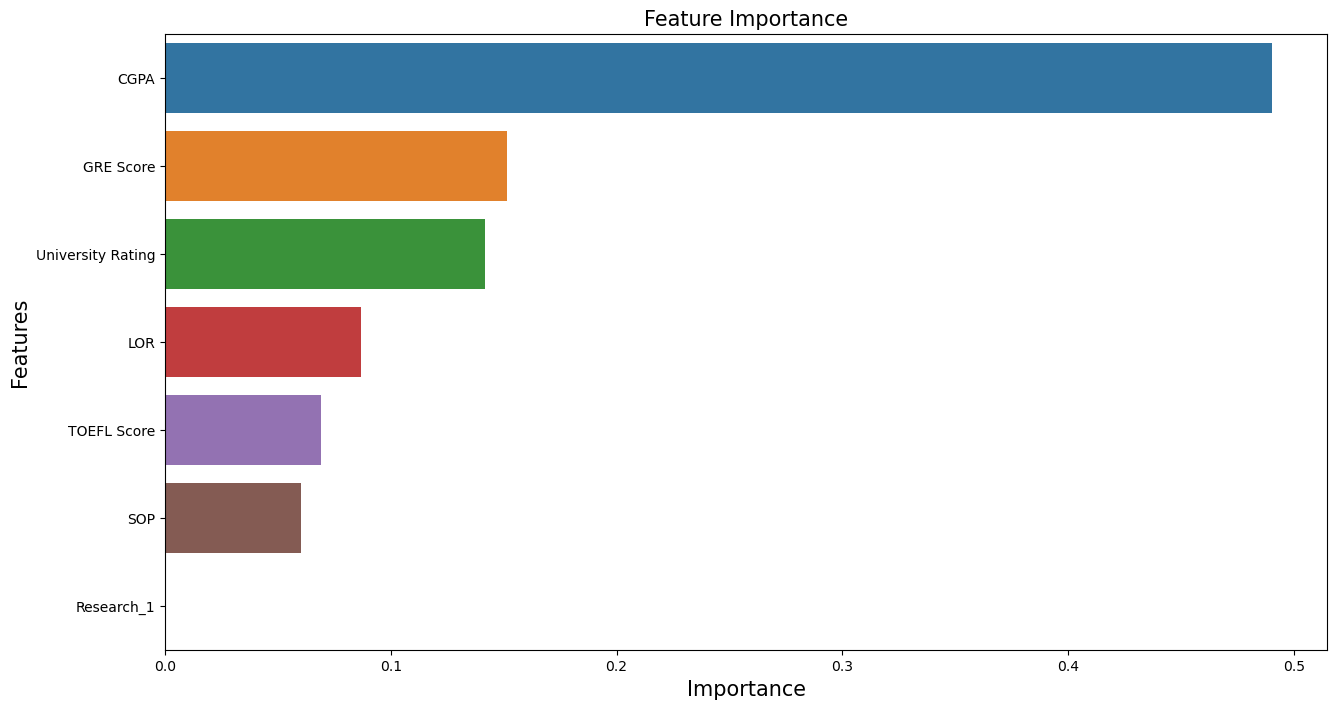

X_train (320, 7)
y_train (320,)
X_test (80, 7)
y_test (80,)


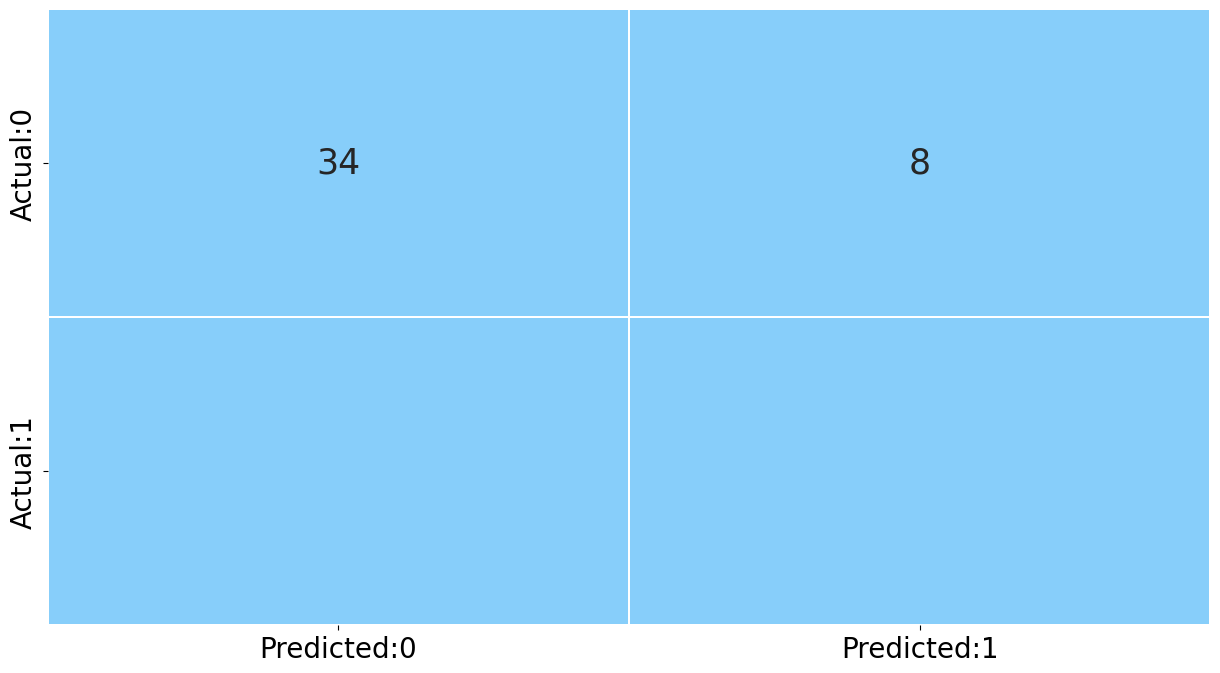

              precision    recall  f1-score   support

           0       0.92      0.81      0.86        42
           1       0.81      0.92      0.86        38

    accuracy                           0.86        80
   macro avg       0.87      0.87      0.86        80
weighted avg       0.87      0.86      0.86        80



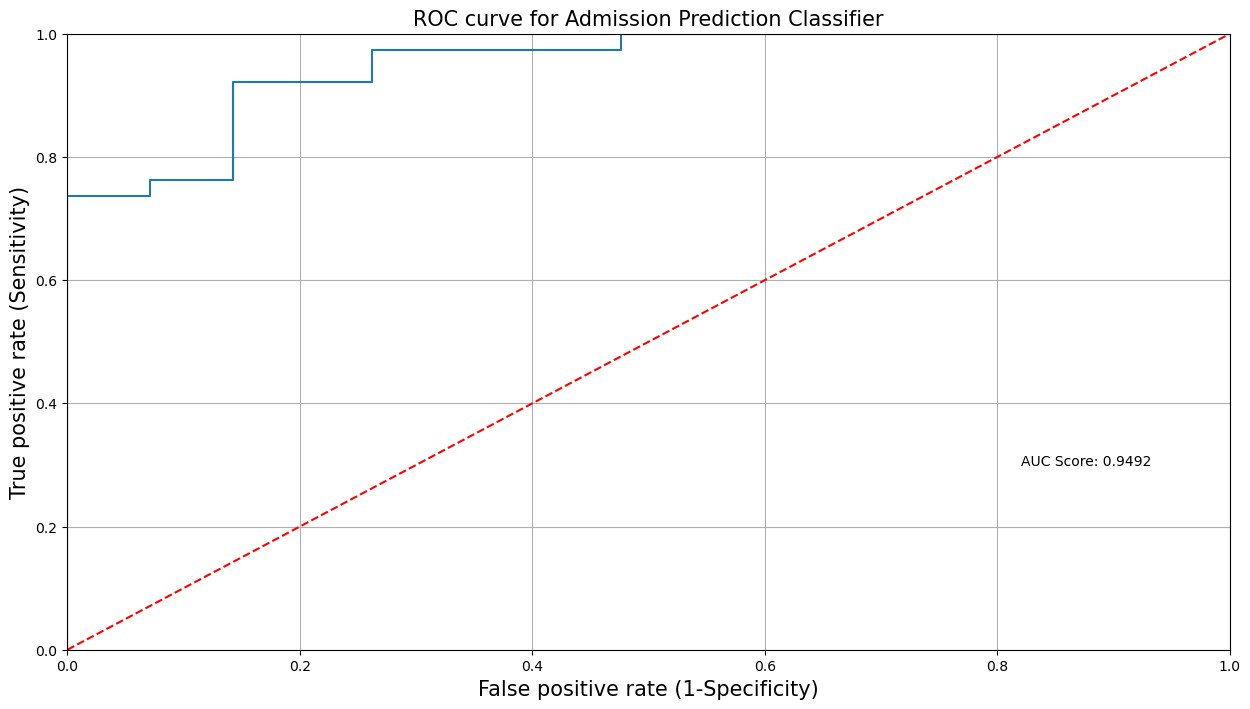

In [5]:


# Display settings for pandas
pd.options.display.max_columns = None
pd.options.display.max_rows = None
pd.options.display.float_format = '{:.6f}'.format

# Set plot size using rcParams
plt.rcParams['figure.figsize'] = [15, 8]

# Load data
df_admissions = pd.read_csv('Admission_Predict-4.csv')

# Drop 'Serial No.' column
df_admissions = df_admissions.drop('Serial No.', axis=1)

# Convert 'Research' to a categorical type
df_admissions['Research'] = df_admissions['Research'].astype('category')

# Target and Feature Split
df_target = df_admissions['Chance of Admit']
df_feature = df_admissions.drop('Chance of Admit', axis=1)

# Dummy variable creation
df_cat = df_feature.select_dtypes(include=['category'])
df_num = df_feature.select_dtypes(include=[np.number])
dummy_var = pd.get_dummies(data=df_cat, drop_first=True)
X = pd.concat([df_num, dummy_var], axis=1)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, df_target, random_state=10, test_size=0.2)

# Confusion matrix plotting function
def plot_confusion_matrix(model):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    conf_matrix = pd.DataFrame(data=cm, columns=['Predicted:0', 'Predicted:1'], index=['Actual:0', 'Actual:1'])
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=ListedColormap(['lightskyblue']), cbar=False, linewidths=0.1, annot_kws={'size': 25})
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.show()

# ROC curve plotting function
def plot_roc(model):
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    plt.plot(fpr, tpr)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.plot([0, 1], [0, 1], 'r--')
    plt.title('ROC curve for Admission Prediction Classifier', fontsize=15)
    plt.xlabel('False positive rate (1-Specificity)', fontsize=15)
    plt.ylabel('True positive rate (Sensitivity)', fontsize=15)
    plt.text(x=0.82, y=0.3, s=f'AUC Score: {round(roc_auc_score(y_test, y_pred_prob), 4)}')
    plt.grid(True)
    plt.show()

# Generalized function to return classification report
def get_test_report(model):
    test_pred = model.predict(X_test)
    return classification_report(y_test, test_pred)

# Train AdaBoost model
ada_model = AdaBoostClassifier(n_estimators=40, random_state=10)
ada_model.fit(X_train, y_train)

# Evaluate AdaBoost model
plot_confusion_matrix(ada_model)
print(get_test_report(ada_model))
plot_roc(ada_model)

# Train GradientBoosting model
gboost_model = GradientBoostingClassifier(n_estimators=150, max_depth=10, random_state=10)
gboost_model.fit(X_train, y_train)

# Evaluate GradientBoosting model
plot_confusion_matrix(gboost_model)
print(get_test_report(gboost_model))
plot_roc(gboost_model)

# Train XGBoost model
xgb_model = XGBClassifier(max_depth=10, gamma=1)
xgb_model.fit(X_train, y_train)

# Evaluate XGBoost model
plot_confusion_matrix(xgb_model)
print(get_test_report(xgb_model))
plot_roc(xgb_model)

# Hyperparameter Tuning for XGBoost
tuning_parameters = {'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6],
                     'max_depth': range(3, 10),
                     'gamma': [0, 1, 2, 3, 4]}
xgb_grid = GridSearchCV(estimator=XGBClassifier(), param_grid=tuning_parameters, cv=3, scoring='roc_auc')
xgb_grid.fit(X_train, y_train)

# Get best parameters and retrain model
best_params = xgb_grid.best_params_
xgb_grid_model = XGBClassifier(learning_rate=best_params.get('learning_rate'), max_depth=best_params.get('max_depth'), gamma=best_params.get('gamma'))
xgb_grid_model.fit(X_train, y_train)

# Evaluate optimized XGBoost model
print('Classification Report for test set:\n', get_test_report(xgb_grid_model))
plot_roc(xgb_grid_model)

# Feature Importance Plot
important_features = pd.DataFrame({'Features': X_train.columns, 'Importance': xgb_grid_model.feature_importances_}).sort_values('Importance', ascending=False)
sns.barplot(x='Importance', y='Features', data=important_features)
plt.title('Feature Importance', fontsize=15)
plt.xlabel('Importance', fontsize=15)
plt.ylabel('Features', fontsize=15)
plt.show()

# initialize the standard scalar
X_scaler = StandardScaler()

# scale all the numerical columns
# standardize all the columns of the dataframe 'df_num'
num_scaled = X_scaler.fit_transform(df_num)

# create a dataframe of scaled numerical variables
# pass the required column names to the parameter 'columns'
df_num_scaled = pd.DataFrame(num_scaled, columns = df_num.columns)

# concat the dummy variables with scaled numeric features to create a dataframe of all independent variables
# 'axis=1' concats the dataframes along columns 
X = pd.concat([df_num_scaled, dummy_var], axis = 1)

# display first five observations
X.head()

# split data into train subset and test subset
# set 'random_state' to generate the same dataset each time you run the code 
# 'test_size' returns the proportion of data to be included in the test set
X_train, X_test, y_train, y_test = train_test_split(X, df_target, random_state = 10, test_size = 0.2)

# check the dimensions of the train & test subset using 'shape'
# print dimension of train set
print('X_train', X_train.shape)
print('y_train', y_train.shape)

# print dimension of test set
print('X_test', X_test.shape)
print('y_test', y_test.shape)

# consider the various algorithms as base learners
base_learners = [('rf_model', RandomForestClassifier(criterion = 'entropy', max_depth = 10, max_features = 'sqrt', 
                                                     max_leaf_nodes = 8, min_samples_leaf = 5, min_samples_split = 2, 
                                                     n_estimators = 50, random_state = 10)),
                 ('KNN_model', KNeighborsClassifier(n_neighbors = 17, metric = 'euclidean')),
                 ('NB_model', GaussianNB())]

# initialize stacking classifier 
# pass the base learners to the parameter, 'estimators'
# pass the Naive Bayes model as the 'final_estimator'/ meta model
stack_model = StackingClassifier(estimators = base_learners, final_estimator = GaussianNB())

# fit the model on train dataset
stack_model.fit(X_train, y_train)

# call the function to plot the confusion matrix
# pass the stack model to the function
plot_confusion_matrix(stack_model)

# compute the performance measures on test data
# call the function 'get_test_report'
# pass the XGBoost model to the function
test_report = get_test_report(stack_model)

# print the performance measures
print(test_report)

# call the function to plot the ROC curve
# pass the stack model to the function
plot_roc(stack_model)
